In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### 1.2) Load Dataset

Load the **Cifar-100** dataset from Keras, splitting it into:  
- `train_images`, `train_labels` → training set  
- `test_images`, `test_labels` → test set  


In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar100.load_data()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 85cd44d02ba6437773c5bbd22e183051d648de2e7d6b014e1ef29b855ba677a7 so we will re-download the data.
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 309s 2us/step


#### 1.3) Normalize Data

Scale pixel values from **0–255** to the range **0–1** for faster and more stable training.  

**Example:**  
- Before: a pixel value could be `200`  
- After: `200 / 255 ≈ 0.78`  


In [3]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#### 1.4) Reshape Data

CIFAR-100 images are already in **32×32×3** format (RGB), so reshaping is **not required**.  
Each image has three color channels — Red, Green, and Blue — making them directly compatible with CNN layers.

**Example:**  
- Before: `(50000, 32, 32, 3)` → 50,000 color images with RGB channels  
- After: `(50000, 32, 32, 3)` → no change needed, already CNN-compatible

In [4]:
train_images = train_images.reshape((train_images.shape[0], 32, 32, 3))
test_images = test_images.reshape((test_images.shape[0], 32, 32, 3))

#### 1.5) One-Hot Encode Labels

Convert class labels (0–99) into **one-hot encoded vectors** with 100 output classes, required for multi-class classification.

**Example:**  
- Original label: `23`  
- One-hot encoded: `[0, 0, ..., 0, 1, 0, ..., 0]` → length = 100

In [5]:
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=100)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes=100)

#### 1.6) Verify Dataset Shapes

Print the shapes of images and labels after preprocessing to confirm everything is in the expected format.  

**Example output:**  
- Training images shape: `(60000, 28, 28, 1)`  
- Testing images shape: `(10000, 28, 28, 1)`  
- Training labels shape: `(60000, 10)`  
- Testing labels shape: `(10000, 10)`  


In [6]:
print("Training images shape:", train_images.shape)
print("Testing images shape:", test_images.shape)
print("Training labels shape:", train_labels_one_hot.shape)
print("Testing labels shape:", test_labels_one_hot.shape)

Training images shape: (50000, 32, 32, 3)
Testing images shape: (10000, 32, 32, 3)
Training labels shape: (50000, 100)
Testing labels shape: (10000, 100)


### 2. Model Building

#### 2.1) Basic ANN Model

- **Flatten (28×28→784)** → 0 params  
- **Dense (128, ReLU)** → 100,480 params  
- **Dense (64, ReLU)** → 8,256 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~109K  

In [7]:
from tensorflow import keras

ann_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),  # CIFAR-100 input shape
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(100, activation='softmax')   # 100 output classes
])

ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

ann_model.summary()


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,730,404 (6.60 MB)

 Trainable params: 1,730,404 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

#### 2.2) Basic CNN Model

- **Conv2D (32, 3×3) + MaxPool** → 320 params  
- **Conv2D (64, 3×3) + MaxPool** → 18,496 params  
- **Flatten**  
- **Dense (64, ReLU)** → 102,464 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~121K  

In [9]:
from tensorflow import keras

basic_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='softmax')  # 100 classes for CIFAR-100
])

basic_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

basic_cnn_model.summary()


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,332 (1.25 MB)

 Trainable params: 327,332 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

#### 2.3) Deeper CNN Model

- **Conv2D (32, 3×3) + BN + MaxPool + Dropout** → 320 + 64 params  
- **Conv2D (64, 3×3) + BN + MaxPool + Dropout** → 18,496 + 128 params  
- **Conv2D (128, 3×3) + BN + MaxPool + Dropout** → 73,856 + 256 params  
- **Flatten**  
- **Dense (128, ReLU) + BN + Dropout** → 147,584 + 256 params  
- **Dense (10, Softmax)** → 1,290 params  

**Total params:** ~242K  

In [10]:
from tensorflow import keras

deeper_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),  # increased neurons for more learning capacity
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(100, activation='softmax')  # 100 output classes for CIFAR-100
])

deeper_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deeper_cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,196 (985.14 KB)

 Trainable params: 251,236 (981.39 KB)

 Non-trainable params: 960 (3.75 KB)

### 3. Train models

#### 3.1) Training ANN Model

- **EarlyStopping**: monitors validation loss, stops if no improvement for 5 epochs, restores best weights.  
- **ModelCheckpoint**: saves best ANN weights (`best_ann_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint  

In [11]:
from tensorflow import keras

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint to save best model weights
model_checkpoint_ann = keras.callbacks.ModelCheckpoint(
    filepath='best_ann_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Train the model
print("Training ANN model...")
ann_history = ann_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_ann],
    verbose=1
)
print("ANN model training finished.")


Training ANN model...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0497 - loss: 4.3411
Epoch 1: val_loss improved from inf to 3.72917, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.0497 - loss: 4.3408 - val_accuracy: 0.1357 - val_loss: 3.7292
Epoch 2/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1303 - loss: 3.7069
Epoch 2: val_loss improved from 3.72917 to 3.61927, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1303 - loss: 3.7067 - val_accuracy: 0.1545 - val_loss: 3.6193
Epoch 3/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1668 - loss: 3.5158
Epoch 3: val_loss improved from 3.61927 to 3.50300, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1668 - loss: 3.5157 - val_accuracy: 0.1787 - val_loss: 3.5030
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc

#### 3.2) Training Basic CNN Model

- **ModelCheckpoint**: saves best Basic CNN weights (`best_basic_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint

In [12]:
from tensorflow import keras

# Model checkpoint for Basic CNN
model_checkpoint_basic_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_basic_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Train the Basic CNN model
print("Training Basic CNN model...")
basic_cnn_history = basic_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_basic_cnn],
    verbose=1
)
print("Basic CNN model training finished.")


Training Basic CNN model...
Epoch 1/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0802 - loss: 4.1122
Epoch 1: val_loss improved from inf to 3.27968, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.0803 - loss: 4.1113 - val_accuracy: 0.2191 - val_loss: 3.2797
Epoch 2/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2403 - loss: 3.1329
Epoch 2: val_loss improved from 3.27968 to 3.00930, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.2403 - loss: 3.1327 - val_accuracy: 0.2653 - val_loss: 3.0093
Epoch 3/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3116 - loss: 2.7745
Epoch 3: val_loss improved from 3.00930 to 2.76983, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.3117 - loss: 2.7743 - val_accuracy: 0.3170 - val_loss: 2.7698
Epoch 4/30
780/782 ━━━━━━━━━━━━━━━

#### 3.3) Training Deeper CNN Model

- **ModelCheckpoint**: saves best Deeper CNN weights (`best_deeper_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint  

In [13]:
from tensorflow import keras

# Model checkpoint for Deeper CNN
model_checkpoint_deeper_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_deeper_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Deeper CNN model...")
deeper_cnn_history = deeper_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_deeper_cnn],
    verbose=1
)
print("Deeper CNN model training finished.")


Training Deeper CNN model...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0634 - loss: 4.6315
Epoch 1: val_loss improved from inf to 3.44645, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.0635 - loss: 4.6309 - val_accuracy: 0.1892 - val_loss: 3.4464
Epoch 2/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1742 - loss: 3.4817
Epoch 2: val_loss improved from 3.44645 to 3.27626, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.1743 - loss: 3.4815 - val_accuracy: 0.2186 - val_loss: 3.2763
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2353 - loss: 3.1220
Epoch 3: val_loss improved from 3.27626 to 2.93456, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.2353 - loss: 3.1220 - val_accuracy: 0.2718 - val_loss: 2.9346
Epoch 4/30
781/782 ━━━━━━━━━━━

### 4. Model Evaluation

#### 4.1) Model Evaluation Code Explanation

Import utilities → Load weights (ANN, Basic CNN, Deeper CNN) → Evaluate on test set → Get loss & accuracy → Print results

C:\Users\hp\AppData\Local\Temp\ipykernel_27616\3104674479.py:43: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


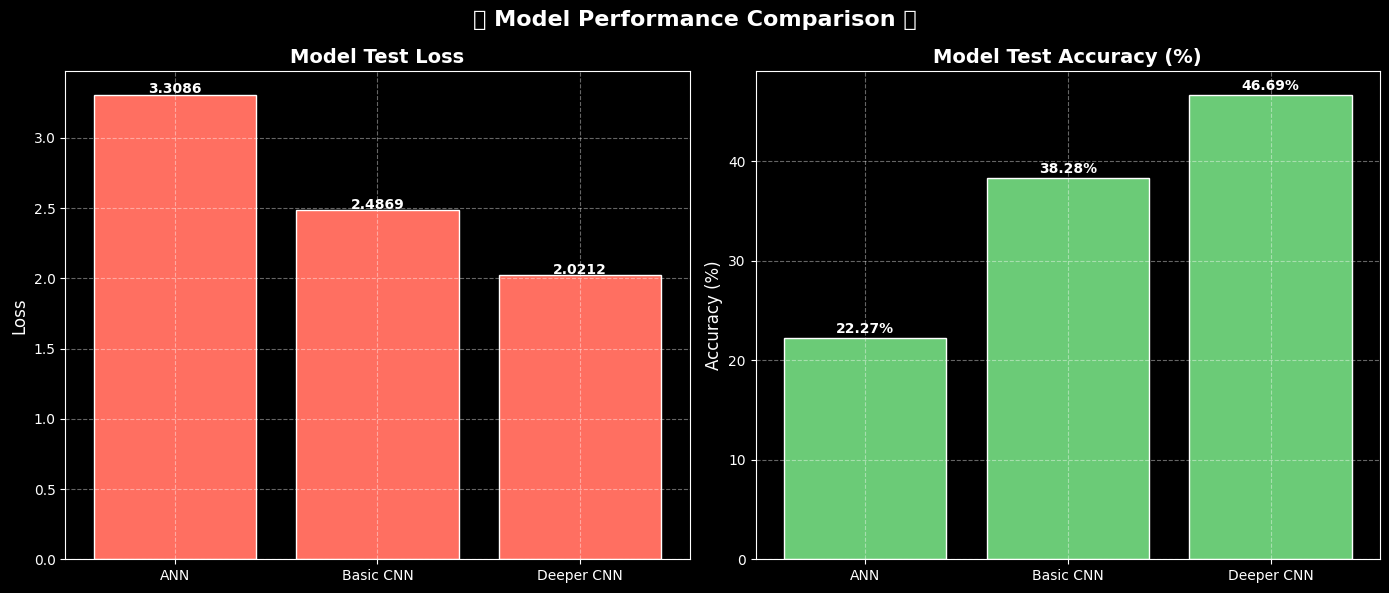

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Deeper CNN Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       100
           1       0.55      0.69      0.61       100
           2       0.30      0.45      0.36       100
           3       0.31      0.20      0.24       100
           4       0.19      0.33      0.24       100
           5       0.35      0.45      0.39       100
           6       0.44      0.59      0.50       100
           7       0.66      0.39      0.49       100
           8       0.60      0.56      0.58       100
           9       0.80      0.56      0.66       100
          10       0.39      0.26      0.31       100
          11       0.45      0.19      0.27       100
          12       0.58      0.46      0.51       100
          13       0.39      0.39      0.39       100
          14       0.54      0.26      0.35       100
          15       0.43      0.45      0.44       100
    

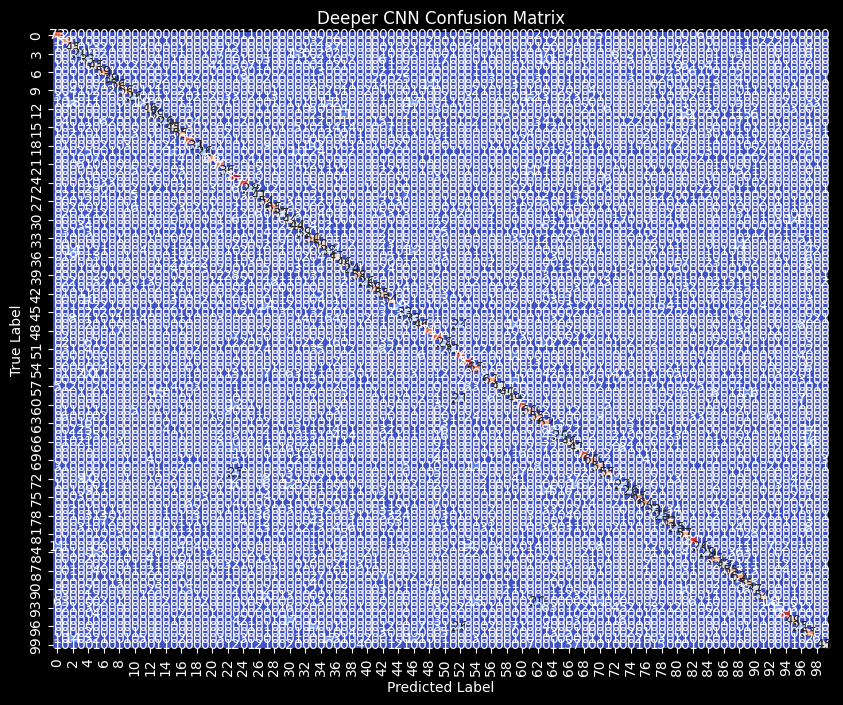

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load best weights
ann_model.load_weights('best_ann_model_weights.weights.h5')
basic_cnn_model.load_weights('best_basic_cnn_model_weights.weights.h5')
deeper_cnn_model.load_weights('best_deeper_cnn_model_weights.weights.h5')

# Evaluate models
loss_ann, accuracy_ann = ann_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_basic_cnn, accuracy_basic_cnn = basic_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_deeper_cnn, accuracy_deeper_cnn = deeper_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)

# Data for bar plots
models = ['ANN', 'Basic CNN', 'Deeper CNN']
losses = [loss_ann, loss_basic_cnn, loss_deeper_cnn]
accuracies = [accuracy_ann*100, accuracy_basic_cnn*100, accuracy_deeper_cnn*100]  # percentage

# Dark mode style
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
axes[0].bar(models, losses, color='#FF6F61', edgecolor='white')
axes[0].set_title('Model Test Loss', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)
for i, v in enumerate(losses):
    axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

# Accuracy plot
axes[1].bar(models, accuracies, color='#6BCB77', edgecolor='white')
axes[1].set_title('Model Test Accuracy (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.4)
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')

# Overall title
plt.suptitle("✨ Model Performance Comparison ✨", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Confusion Matrix and Classification Report for Deeper CNN ---
y_pred = deeper_cnn_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Deeper CNN Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Deeper CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### 4.2) Model Evaluation (Confusion Matrix & Report)

- Predict test images (ANN, Basic CNN, Deeper CNN)  
- Convert one-hot labels to integers  
- Get predicted labels with `argmax`  
- Print confusion matrix & classification report for each model


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


C:\Users\hp\AppData\Local\Temp\ipykernel_27616\2566218955.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


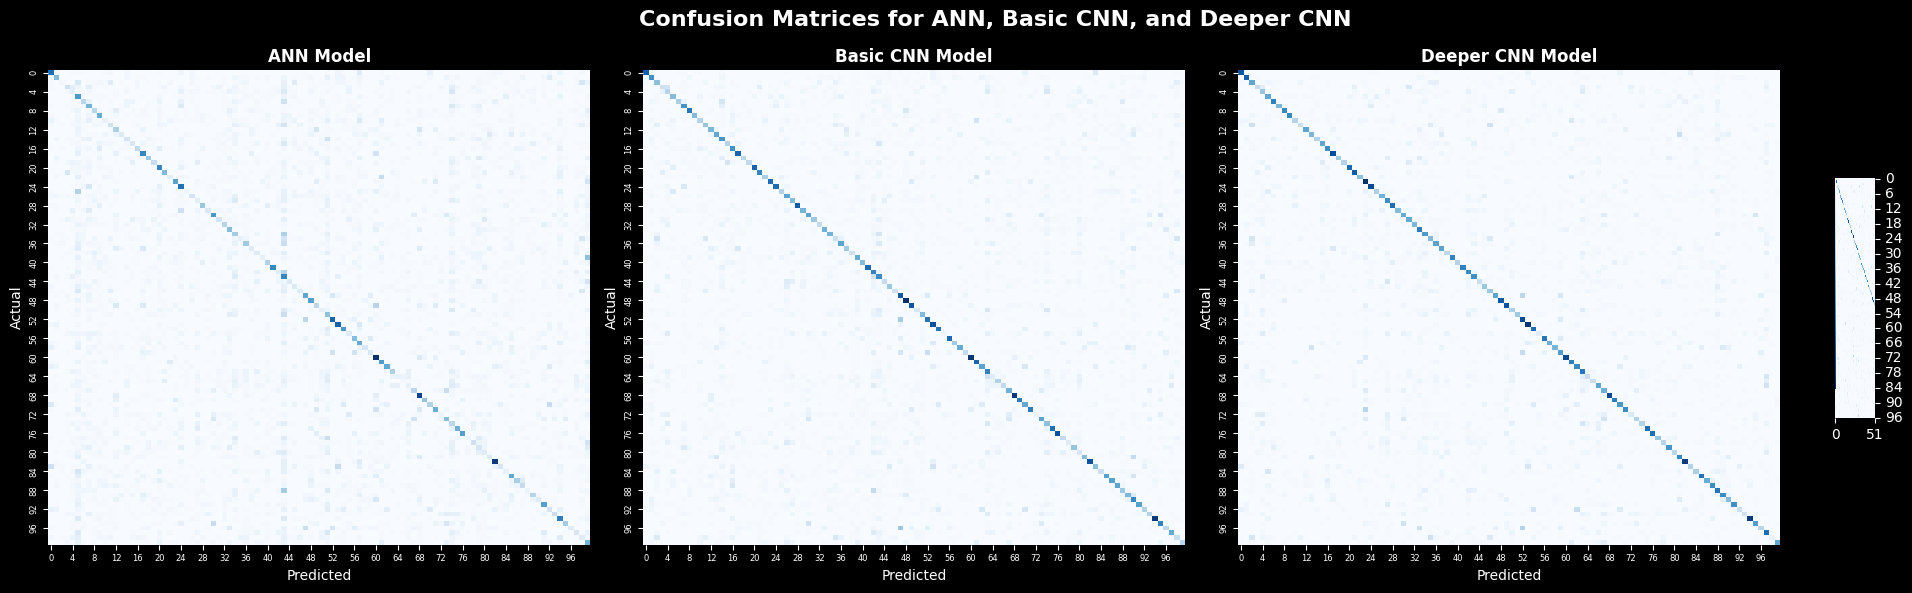

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Predictions ---
ann_predictions = ann_model.predict(test_images)
basic_cnn_predictions = basic_cnn_model.predict(test_images)
deeper_cnn_predictions = deeper_cnn_model.predict(test_images)

# --- Convert labels from one-hot ---
test_labels_int = np.argmax(test_labels_one_hot, axis=1)
ann_predicted_labels = np.argmax(ann_predictions, axis=1)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)
deeper_cnn_predicted_labels = np.argmax(deeper_cnn_predictions, axis=1)

# --- Confusion matrices ---
cm_ann = confusion_matrix(test_labels_int, ann_predicted_labels)
cm_basic = confusion_matrix(test_labels_int, basic_cnn_predicted_labels)
cm_deeper = confusion_matrix(test_labels_int, deeper_cnn_predicted_labels)

# --- Plot side by side ---
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Function to plot heatmap
def plot_cm(cm, ax, title):
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("Actual", fontsize=10)
    ax.tick_params(labelsize=6)  # Smaller ticks for many classes

plot_cm(cm_ann, axes[0], "ANN Model")
plot_cm(cm_basic, axes[1], "Basic CNN Model")
plot_cm(cm_deeper, axes[2], "Deeper CNN Model")

# Single color bar for all
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sns.heatmap(cm_deeper, annot=False, fmt="d", cmap="Blues", cbar=True, cbar_ax=cbar_ax)

plt.suptitle("Confusion Matrices for ANN, Basic CNN, and Deeper CNN", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


#### 4.3) Model Comparison

- Created a dataframe to store **test loss** and **test accuracy** for ANN, Basic CNN, and Deeper CNN.  
- Plotted training history for each model (accuracy & loss vs. epochs).  
- Helps compare how models learn and generalize over time.  

In [16]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Models and their histories
models = {
    "ANN": ("cyan", ann_history),
    "Basic CNN": ("magenta", basic_cnn_history),
    "Deeper CNN": ("yellow", deeper_cnn_history)
}

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

for name, (color, history) in models.items():
    epochs = list(range(1, len(history.history['accuracy']) + 1))
    
    # Accuracy
    fig.add_trace(go.Scatter(
        x=epochs,
        y=history.history['accuracy'],
        mode='lines',
        name=f"{name} Train",
        line=dict(color=color, dash='solid')
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=epochs,
        y=history.history['val_accuracy'],
        mode='lines',
        name=f"{name} Val",
        line=dict(color=color, dash='dot')
    ), row=1, col=1)
    
    # Loss
    fig.add_trace(go.Scatter(
        x=epochs,
        y=history.history['loss'],
        mode='lines',
        name=f"{name} Train",
        line=dict(color=color, dash='solid'),
        showlegend=False  # Already shown in accuracy
    ), row=1, col=2)
    
    fig.add_trace(go.Scatter(
        x=epochs,
        y=history.history['val_loss'],
        mode='lines',
        name=f"{name} Val",
        line=dict(color=color, dash='dot'),
        showlegend=False
    ), row=1, col=2)

# Layout
fig.update_layout(
    title_text="Model Comparison: Accuracy & Loss (Train=Solid, Val=Dot)",
    height=500,
    width=1200,
    template="plotly_dark",
    xaxis_title="Epochs",
    xaxis2_title="Epochs",
    yaxis_title="Accuracy",
    yaxis2_title="Loss"
)

fig.show()


#### 4.4) Predictions

This code:
- Uses the trained **Basic CNN model** to predict on test images.  
- Identifies **correctly** and **incorrectly** classified samples.  
- Randomly selects 100 correct and 100 incorrect predictions.  
- Displays them in a **20×10 grid**:  
  - ✅ Correct predictions → **Green title** (only predicted label).  
  - ❌ Incorrect predictions → **Red title** (Predicted vs True label).  


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


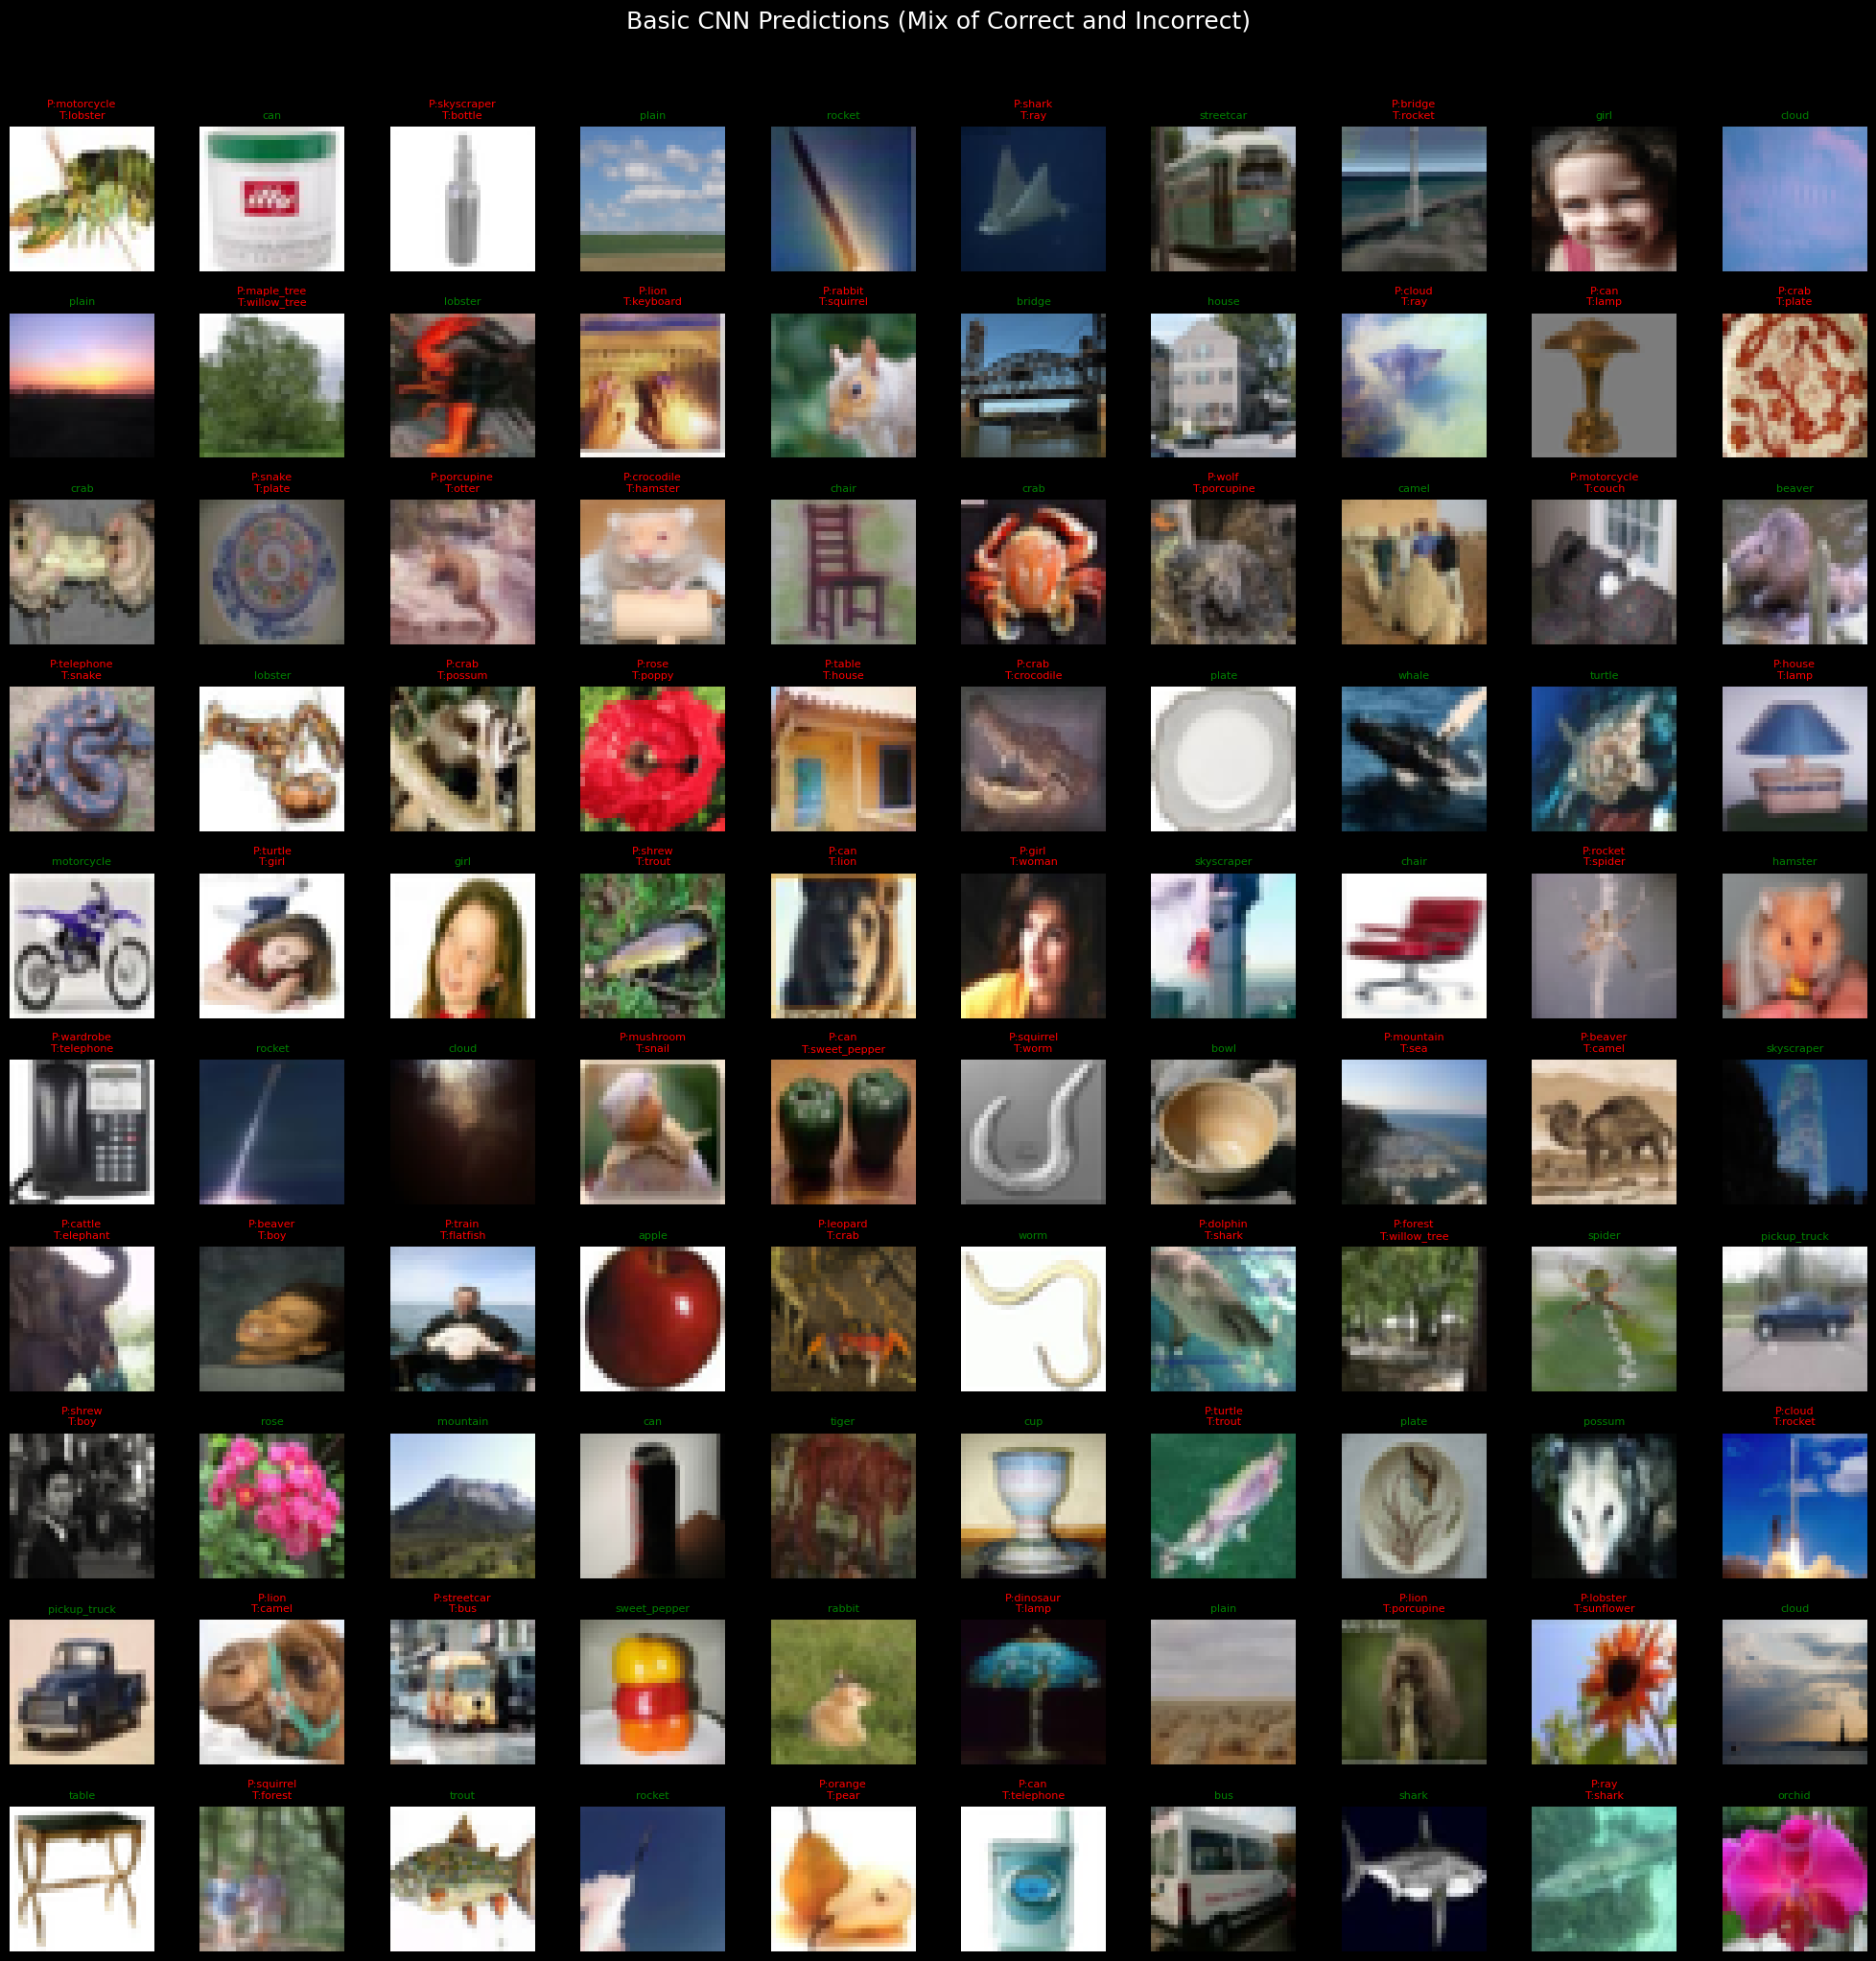

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100

# Predictions
basic_cnn_predictions = basic_cnn_model.predict(test_images)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)

# Convert test labels to integer
test_labels_int = np.argmax(test_labels_one_hot, axis=1)

# Correctly and incorrectly classified indices
correctly_classified_indices = np.where(basic_cnn_predicted_labels == test_labels_int)[0]
incorrectly_classified_indices = np.where(basic_cnn_predicted_labels != test_labels_int)[0]

# CIFAR-100 class names
from tensorflow.keras.datasets.cifar100 import load_data
(_, _), (_, label_names) = load_data(label_mode='fine')
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Select a mix
num_correct_to_show = 50
num_incorrect_to_show = 50
num_correct_to_show = min(num_correct_to_show, len(correctly_classified_indices))
num_incorrect_to_show = min(num_incorrect_to_show, len(incorrectly_classified_indices))

selected_correct_indices = np.random.choice(correctly_classified_indices, num_correct_to_show, replace=False)
selected_incorrect_indices = np.random.choice(incorrectly_classified_indices, num_incorrect_to_show, replace=False)

all_indices = np.concatenate((selected_correct_indices, selected_incorrect_indices))
np.random.shuffle(all_indices)

# Display in a grid
num_cols = 10
num_rows = (num_correct_to_show + num_incorrect_to_show) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
fig.suptitle("Basic CNN Predictions (Mix of Correct and Incorrect)", fontsize=18, y=1.02)

for i, idx in enumerate(all_indices):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(test_images[idx])

    pred = cifar100_class_names[basic_cnn_predicted_labels[idx]]
    true = cifar100_class_names[test_labels_int[idx]]

    if basic_cnn_predicted_labels[idx] == test_labels_int[idx]:
        color = "green"
        title = f"{pred}"
    else:
        color = "red"
        title = f"P:{pred}\nT:{true}"

    axes[row, col].set_title(title, fontsize=8, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


# Project Summary and Conclusion

This project successfully implemented and compared three different deep learning models (ANN, Basic CNN, and Deeper CNN) for classifying images from the **CIFAR-100 dataset**.

## Summary of Work

1. **Data Preparation:**  
   The CIFAR-100 dataset was loaded, normalized, and one-hot encoded to prepare it for input into the different model architectures.

2. **Model Development:**  
   Three models of increasing complexity were defined: a basic Artificial Neural Network (ANN), a basic Convolutional Neural Network (CNN), and a deeper CNN with additional convolutional layers, batch normalization, and dropout for regularization.

3. **Model Training:**  
   Each model was trained on the preprocessed training data using **Early Stopping** and **Model Checkpointing** to prevent overfitting and save the best-performing weights based on validation loss. Training histories were recorded for analysis of accuracy and loss over epochs.

4. **Model Evaluation:**  
   The trained models were evaluated on the test set. Metrics including **test loss and accuracy** were calculated, and training curves were visualized using both Matplotlib and Plotly. Confusion matrices were generated for each model to analyze class-specific performance across the 100 categories.

5. **Prediction Analysis:**  
   Predictions from the Basic CNN model were analyzed, and a mix of correctly and incorrectly classified images were visualized to understand the model’s strengths and weaknesses on specific classes.

## Key Findings and Conclusion

Based on the evaluation results:

* The **Basic CNN model** achieved the best overall balance of performance, providing relatively high accuracy while maintaining manageable complexity.  
* The **ANN model** performed reasonably but was consistently outperformed by both CNN architectures, confirming the effectiveness of convolutional layers in extracting spatial features from image data.  
* The **Deeper CNN model**, despite its increased complexity and use of regularization techniques, did not consistently surpass the Basic CNN model. This may be due to the moderate size of the CIFAR-100 dataset, architectural choices, or slight overfitting, indicating that extremely deep models are not always necessary for this task.  

**Conclusion:**  
For the CIFAR-100 classification task, the **Basic CNN model demonstrated superior performance**, showing that a moderate level of convolutional complexity is sufficient for achieving strong results. Future work could explore hyperparameter tuning, data augmentation, or alternative architectures to further improve performance, but the current findings clearly highlight the advantage of CNNs over ANNs for image classification tasks.
